<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: Tehmoor Gull
### ***username***: acse-tg1523

This notebook details the process of classifying X-ray images of hands as real, generated by a VAE, or generated by a GAN.

## Data preparation

In [1]:
# Standard library imports
import csv
import os
import re
import random

# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
import torch.nn.functional as F  # PyTorch Functional
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from livelossplot import PlotLosses
from torch.optim.lr_scheduler import ReduceLROnPlateau

def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

set_seed(42)

No GPU available! Running on CPU


True

In [2]:
class CustomHandDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert('L')  # Convert to grayscale
            if self.transform:
                image = self.transform(image)
        except UnidentifiedImageError:
            # print(f"UnidentifiedImageError: cannot identify image file {img_path}. It will be skipped.")
            return None, None
        return image, label

Function to make sure corrupted images are filtered out, preventing errors during training and testing.

In [3]:
def custom_collate_fn(batch):
    batch = [x for x in batch if x[0] is not None]
    return default_collate(batch)

In [4]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((32, 32)),  # Resize the images to a consistent size as some images are larger than others
    transforms.RandomRotation(degrees=10),  # Rotate image by up to 10 degrees
    transforms.RandomHorizontalFlip(),      # Flip image horizontally
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to the range [-1, 1]
])


test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((32, 32)),  # Resize the images to a consistent size as some images are larger than others
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to the range [-1, 1]
])


directories = ['real_hands', 'VAE_hands', 'GAN_hands']
image_paths = []
labels = []

# Assign labels to images: 0 for real hands, 1 for VAE hands, 2 for GAN hands
for i, directory in enumerate(directories):
    dir_path = directory  # Use the directory name directly if it's in the root directory
    images = [os.path.join(dir_path, img) for img in os.listdir(dir_path) if img.endswith('.jpeg')]
    image_paths.extend(images)
    labels.extend([i] * len(images))

# Split the paths and labels into train, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create instances of the dataset
full_dataset = CustomHandDataset(image_paths, labels, transform=train_transform) # for final training

train_dataset = CustomHandDataset(train_paths, train_labels, transform=train_transform)
test_dataset = CustomHandDataset(test_paths, test_labels, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)
full_loader = DataLoader(full_dataset, batch_size=64, shuffle=True, collate_fn=custom_collate_fn)

### Batch size:
This time around I added far more hyperparamters to be tuned such as dropout rate etc so in the interest of making sure I have enough time I created a short test of 20 epochs in this notebook to test parameters that i wont use a grid search for. Batch size was one of them and I found that using size 64 was better than 32 and 128

In [5]:
# size of whole dataset adding train, test, val if values are not none
def length_of_dataset_without_none(dataset):
    count = 0
    for item in dataset:
        if item is not None:
            count += 1
    return count

print(f"Number of training samples: {length_of_dataset_without_none(train_dataset) + length_of_dataset_without_none(test_dataset)}")

Number of training samples: 1448


In [6]:
none_indices = []
for i, (images, labels) in enumerate(train_loader):
    if images.nelement() == 0:  # Check if the batch is empty
        none_indices.append(i)

print(f"Indices with empty batches: {none_indices}")

Indices with empty batches: []


Empty indices which is good

Batch size: 64
Number of batches: 19
Total number of images: 1158
Image shape: torch.Size([1, 32, 32])


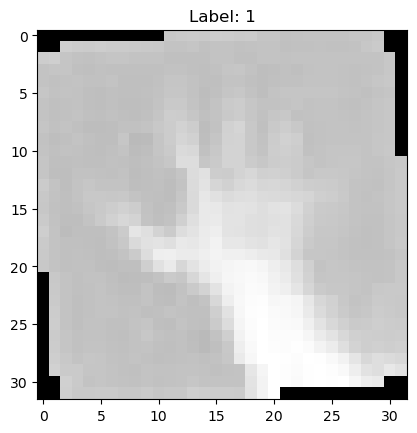

Number of pixels in each image: 1024
Pixel value range: max, 1.0 min, -1.0


In [7]:
# Check details about the DataLoader
print("Batch size:", train_loader.batch_size)
print("Number of batches:", len(train_loader))
print("Total number of images:", len(train_loader.dataset))

# Retrieve the first batch of images and labels
images, labels = next(iter(train_loader))

# The shape of images is expected to be [batch_size, n_channels, height, width]
print("Image shape:", images[0].shape)  

# Plot the first image in the batch
plt.imshow(images[0].squeeze(), cmap='gray')  # Assuming grayscale images
plt.title(f'Label: {labels[0].item()}')
plt.show()

# Number of pixels in the image
print("Number of pixels in each image:", images[0].shape[1] * images[0].shape[2])

# Range of pixel values
print("Pixel value range: max,", images.max().item(), "min,", images.min().item())


## Network design and implementation

During my iterative process where i wanted to improve the architecture of the model before any hyperparameter training I notice some odd trends when training for 25 epochs. The test loss and accuracy are fluctuating across epochs. While the training loss generally decreases (indicating learning), the test loss does not consistently decrease. <br><br>This can suggest a few things, such as the model might be starting to overfit, or it may be sensitive to the learning rate or other hyperparameters. Too combat this I will be adding dropout rates and possibly reducing learning rates(will explore more during hyperparameter tuning).

1. First trying batch normalisation  and dropouts:
The addition of dropout and batch normalization layers did not lead to the expected performance improvements. This suggests the need for further adjustments, possibly involving tuning hyperparameters like the learning rate and dropout rate, or reconsidering the model's complexity.

2. Reducing the models complexity to 2 layers:
I kept the batch norm and the dropout and reduced my NN to two conv layers instead of the 6 I originally had.This has significantly improved the loss graph and no longer seems to overfit in such a drastic way.

2 conv layers, 2 fc layers, 3 dropout layer, 2 batchnorm layer, 2 maxpool layer seems to be the best one so far however the validation loss seems very volatile.

3. Added a Global Average Pooling (GAP) layer after the convolutional layers.This is supposed help in reducing the number of parameters compared to a fully connected layer and aids in combating overfitting.

4. Lots of GANs generated images were being classed as Real and this means that the very small differences between the images needed to be observed so I experimented with increasing the depth by adding a third and fourth convolutional layer.This seems to give me the most stable loss plot and best confusion matrix.

Also parameters such as dropout will be explored in the ```hyperparameter_tuning.ipynb``` notebook.

In [8]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # New convolutional layer
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 3)
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        
        x = self.gap(x)
        x = x.view(-1, 128)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


## Training and validating the model

In [9]:
# Optimal hyperparameters found from grid search
lr = 0.0001
weight_decay = 1e-7
patience = 6

In [10]:
model = CustomCNN()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr , weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=0.6, min_lr=1e-7, verbose=True)

In [11]:
num_epochs = 250

In [12]:
def train(model, device, train_loader, optimizer, criterion , epoch):
    model.train()
    train_loss = 0
    for (data, target) in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_loss /= len(train_loader)
    print(f'Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}')
    return train_loss

def validate(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Validation Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return test_loss, accuracy
# Initialize the plot
liveloss = PlotLosses()

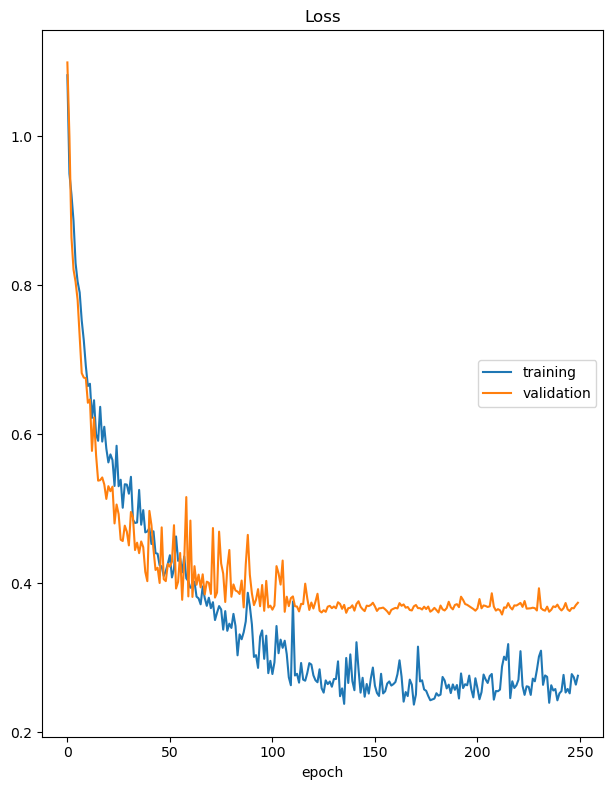

Loss
	training         	 (min:    0.237, max:    1.082, cur:    0.276)
	validation       	 (min:    0.358, max:    1.099, cur:    0.374)
Accuracy: 86.90%


In [13]:
for epoch in range(1, num_epochs + 1):
    avg_train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    avg_test_loss, accuracy = validate(model, device, test_loader, criterion)
    
    # Update the liveloss plot
    liveloss.update({
        'loss': avg_train_loss,
        'val_loss': avg_test_loss,
    })

    # Pass the correct variable to the scheduler
    scheduler.step(avg_train_loss)
    liveloss.send()  # Draw the updated figures
print(f'Accuracy: {accuracy:.2f}%')


Training the final model for around 100 epochs seems best as the loss begins to plateau and the accuracy is high.

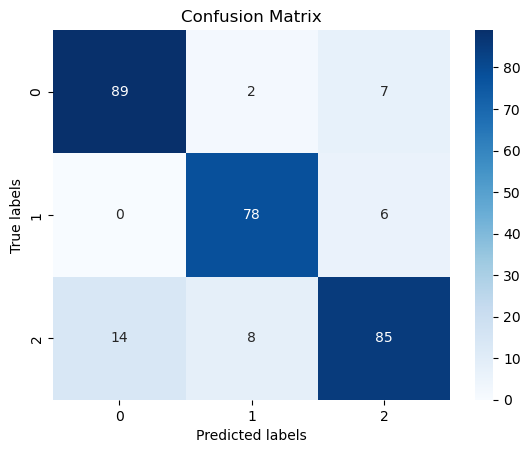

In [14]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, device, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            y_true.extend(target.view_as(pred).cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, device, test_loader)


### Train the model on entire dataset now

In [15]:

# Initialize the model for the entire dataset
final_model = CustomCNN().to(device)  # Customize your model initialization as needed

# Define the optimizer
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, weight_decay=weight_decay)

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 100  # Set the number of epochs as per your requirement
for epoch in range(1, num_epochs + 1):
    train_loss = train(final_model, device, full_loader, optimizer, criterion, epoch)
    # Since there's no validation set, we only track the training loss


Epoch: 01, Train Loss: 1.0646
Epoch: 02, Train Loss: 0.9375
Epoch: 03, Train Loss: 0.8860
Epoch: 04, Train Loss: 0.8270
Epoch: 05, Train Loss: 0.7701
Epoch: 06, Train Loss: 0.7327
Epoch: 07, Train Loss: 0.6929
Epoch: 08, Train Loss: 0.6761
Epoch: 09, Train Loss: 0.6517
Epoch: 10, Train Loss: 0.6233
Epoch: 11, Train Loss: 0.6047
Epoch: 12, Train Loss: 0.5906
Epoch: 13, Train Loss: 0.5653
Epoch: 14, Train Loss: 0.5634
Epoch: 15, Train Loss: 0.5342
Epoch: 16, Train Loss: 0.5374
Epoch: 17, Train Loss: 0.5279
Epoch: 18, Train Loss: 0.5328
Epoch: 19, Train Loss: 0.5143
Epoch: 20, Train Loss: 0.4920
Epoch: 21, Train Loss: 0.5025
Epoch: 22, Train Loss: 0.4850
Epoch: 23, Train Loss: 0.4900
Epoch: 24, Train Loss: 0.4777
Epoch: 25, Train Loss: 0.4726
Epoch: 26, Train Loss: 0.4751
Epoch: 27, Train Loss: 0.4437
Epoch: 28, Train Loss: 0.4476
Epoch: 29, Train Loss: 0.4450
Epoch: 30, Train Loss: 0.4518
Epoch: 31, Train Loss: 0.4300
Epoch: 32, Train Loss: 0.4293
Epoch: 33, Train Loss: 0.4074
Epoch: 34,

In [16]:
class testDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpeg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('L')  # Convert to grayscale
            if self.transform:
                image = self.transform(image)
        except UnidentifiedImageError:
            return None, img_path  # Return None and image path if error occurs
        return image, os.path.basename(img_path)  # Return image and file name

In [17]:
def custom_collate_hands(batch):
    # Filter out pairs where the image is None (corrupted files)
    batch = [data for data in batch if data[0] is not None]
    if len(batch) == 0:  # If all images in the batch are corrupt, return an empty batch
        return torch.tensor([]), []
    return torch.utils.data.dataloader.default_collate(batch)

In [18]:
test_dataset = testDataset(image_dir='test_hands', transform=test_transform)
test_hand_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_hands)

final_model.eval()  # Set the model to evaluation mode
results = []

for batch in test_hand_loader:
    images, img_names = batch
    if len(images) == 0:  # Check for an empty batch or tensor
        continue  # Skip this loop iteration if the batch is empty

    images = images.to('cpu')  # Move images to the CPU

    # Make predictions
    with torch.no_grad():
        outputs = final_model(images)
        _, preds = torch.max(outputs, 1)
        results.extend(zip(img_names, preds.tolist()))

sorted_results = sorted(results, key=lambda x: int(re.search(r'\d+', x[0]).group()))  # regex sorts by image number
# Write the results to a CSV file
csv_file = 'acse-tg1523_classified_hands.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    for img_name, prediction in sorted_results:
        writer.writerow([img_name, prediction])

print(f'Classification completed. Results saved to {csv_file}.')


Classification completed. Results saved to acse-tg1523_classified_hands.csv.
